# Image classification with neural networks
In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

- overall test-set accuracy, measured however you think is appropriate
- show some of the example images from the test set, together with your model's predicted classes.
- a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

First of all, let's import the libraries that are used in this question.

In [50]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn.functional as F

Originally, the image is 64pixels x 64 pixels, and with that the accuracy is around 73%.

By resizing the images to 128, the accuracy is increased. 

There is no need to resize them to 256, since it will take a long time to train the model and the accuracy is almost the same as resizing them to 128.

Then we split into 80/20 training-testing sets.

In [106]:
# resize image to 128 x 128
transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the dataset using ImageFolder
df = ImageFolder(root='D:/EuroSAT_RGB', transform=transformation)

# Split into 80/20 training-testing sets
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_df, test_df = torch.utils.data.random_split(df, [train_size, test_size])

# Create data loaders for training and test sets
batch_size = 64
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)

# Get classes
class_labels = df.classes


Let's construct two models, the first one is a pre-defined model resnet18. (ref: https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/) The second model is the one I defined.

In [119]:
# pre-defined model
model = models.resnet18(pretrained=True)

# self-defined model
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_labels))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) #flattening the tensor
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)

model2 = ImageClassifier()

Training the pre-defined model takes 67min to finish. \
Epoch [1/10] Loss: 0.4465 \
Epoch [2/10] Loss: 0.0628 \
Epoch [3/10] Loss: 0.0141 \
Epoch [4/10] Loss: 0.2017 \
Epoch [5/10] Loss: 0.0144 \
Epoch [6/10] Loss: 0.0130 \
Epoch [7/10] Loss: 0.2984 \
Epoch [8/10] Loss: 0.1000 \
Epoch [9/10] Loss: 0.0091 \
Epoch [10/10] Loss: 0.1928 \
Training completed.

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

print("Training completed.")


Epoch [1/10] Loss: 0.4465
Epoch [2/10] Loss: 0.0628
Epoch [3/10] Loss: 0.0141
Epoch [4/10] Loss: 0.2017
Epoch [5/10] Loss: 0.0144
Epoch [6/10] Loss: 0.0130
Epoch [7/10] Loss: 0.2984
Epoch [8/10] Loss: 0.1000
Epoch [9/10] Loss: 0.0091
Epoch [10/10] Loss: 0.1928
Training completed.


The pre-defined model has a test set accuracy of 95.52%

In [125]:
model.eval()
correct = 0
total = 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_classes.extend(predicted.cpu().numpy())
        actual_classes.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Set Accuracy: {accuracy:.2f}%")


Test Set Accuracy: 95.52%


Predicted classes: 
'Industrial', 'River', 'PermanentCrop', 'AnnualCrop', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 
'Forest', 'Industrial', 'Highway', 'River', 'River', 'PermanentCrop', 'Industrial', 'Pasture', 
'SeaLake', 'Forest', 'Industrial', 'River', 'SeaLake', 'Residential', 'Forest', 'HerbaceousVegetation',
'SeaLake', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 'Residential', 'Pasture', 'Pasture', 
'SeaLake', 'Residential', 'SeaLake', 'Forest', 'Pasture', 'River', 'Forest', 'Highway', 
'SeaLake', 'Highway', 'Highway', 'AnnualCrop', 'Forest', 'SeaLake', 'River', 'AnnualCrop', 
'Pasture', 'SeaLake', 'Residential', 'HerbaceousVegetation', 'AnnualCrop', 'PermanentCrop', 'River', 'HerbaceousVegetation', 
'AnnualCrop', 'AnnualCrop', 'HerbaceousVegetation', 'SeaLake', 'Pasture', 'Highway', 'Residential', 'HerbaceousVegetation'

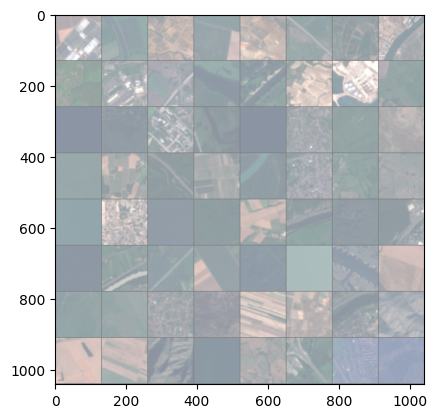

Predicted classes: ['Industrial', 'River', 'PermanentCrop', 'AnnualCrop', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 'Forest', 'Industrial', 'Highway', 'River', 'River', 'PermanentCrop', 'Industrial', 'Pasture', 'SeaLake', 'Forest', 'Industrial', 'River', 'SeaLake', 'Residential', 'Forest', 'HerbaceousVegetation', 'SeaLake', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 'Residential', 'Pasture', 'Pasture', 'SeaLake', 'Residential', 'SeaLake', 'Forest', 'Pasture', 'River', 'Forest', 'Highway', 'SeaLake', 'Highway', 'Highway', 'AnnualCrop', 'Forest', 'SeaLake', 'River', 'AnnualCrop', 'Pasture', 'SeaLake', 'Residential', 'HerbaceousVegetation', 'AnnualCrop', 'PermanentCrop', 'River', 'HerbaceousVegetation', 'AnnualCrop', 'AnnualCrop', 'HerbaceousVegetation', 'SeaLake', 'Pasture', 'Highway', 'Residential', 'HerbaceousVegetation']


In [126]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images
dataiter = iter(test_loader)
inputs, labels = next(dataiter)
inputs, labels = inputs.to(device), labels.to(device)

# Make predictions on the test images
model.eval()
with torch.no_grad():
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

# Display the images and predictions
imshow(torchvision.utils.make_grid(inputs.cpu()))
print("Predicted classes:", [class_labels[pred] for pred in predicted.cpu().numpy()])


We then construct the confusion matrix on the pre-defined model. 

Prediction error occurs the most when the model predicts the image to be annualcrop when the image actually is a permanentcrop. 

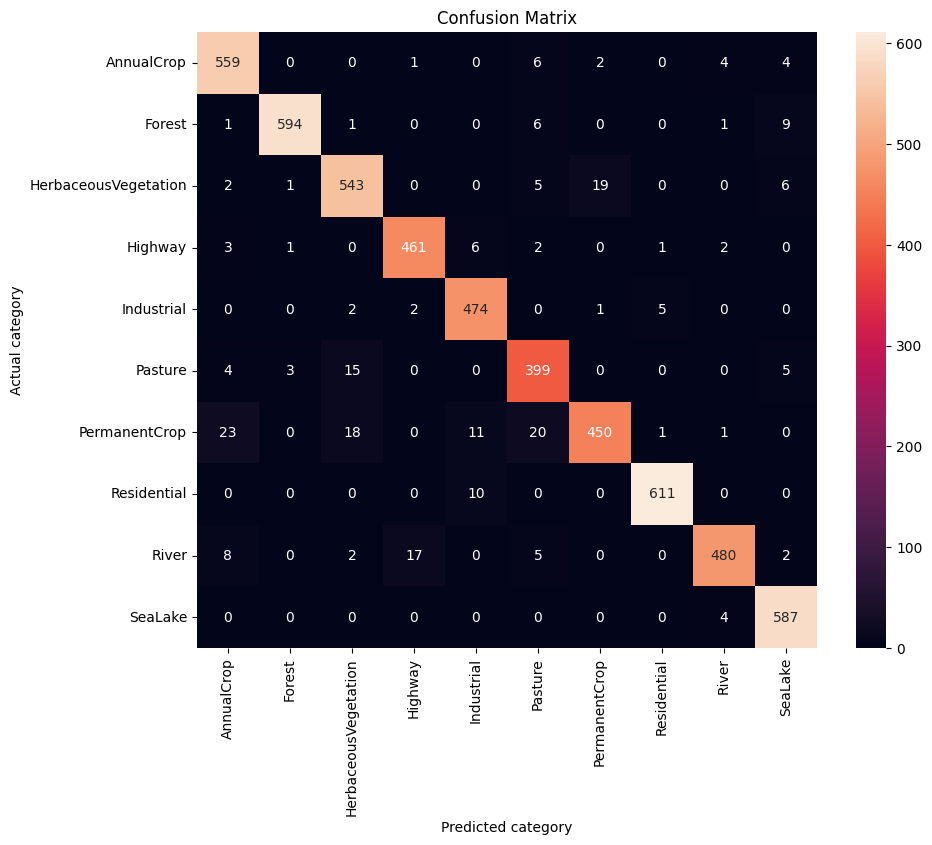

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(actual_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted category')
plt.ylabel('Actual category')
plt.title('Confusion Matrix')
plt.show()

Training the self-defined model takes 64min to finish. \
Epoch [1/10] Loss: 0.7241 \
Epoch [2/10] Loss: 1.2311 \
Epoch [3/10] Loss: 0.7009 \
Epoch [4/10] Loss: 0.2943 \
Epoch [5/10] Loss: 0.2837 \
Epoch [6/10] Loss: 0.3382 \
Epoch [7/10] Loss: 0.1655 \
Epoch [8/10] Loss: 0.2767 \
Epoch [9/10] Loss: 0.0953 \
Epoch [10/10] Loss: 0.1887 \
Training completed.

In [120]:
model2.to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model2.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f}")

print("Training completed.")

Epoch [1/10] Loss: 0.7241
Epoch [2/10] Loss: 1.2311
Epoch [3/10] Loss: 0.7009
Epoch [4/10] Loss: 0.2943
Epoch [5/10] Loss: 0.2837
Epoch [6/10] Loss: 0.3382
Epoch [7/10] Loss: 0.1655
Epoch [8/10] Loss: 0.2767
Epoch [9/10] Loss: 0.0953
Epoch [10/10] Loss: 0.1887
Training completed.


The self-defined model has a test set accuracy of 83.89%

In [121]:
model2.eval()
correct = 0
total = 0
predicted_classes = []
actual_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_classes.extend(predicted.cpu().numpy())
        actual_classes.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Set Accuracy: {accuracy:.2f}%")

Test Set Accuracy: 83.89%


Predicted classes: 
'Industrial', 'River', 'PermanentCrop', 'AnnualCrop', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 
'Pasture', 'Industrial', 'Highway', 'AnnualCrop', 'River', 'PermanentCrop', 'Industrial', 'Pasture', 
'SeaLake', 'Forest', 'Industrial', 'River', 'SeaLake', 'Residential', 'Forest', 'HerbaceousVegetation', 
'SeaLake', 'AnnualCrop', 'Highway', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'PermanentCrop', 
'SeaLake', 'Residential', 'SeaLake', 'Forest', 'AnnualCrop', 'River', 'Forest', 'Highway', 
'SeaLake', 'Highway', 'Highway', 'AnnualCrop', 'Forest', 'SeaLake', 'River', 'AnnualCrop', 
'Pasture', 'Pasture', 'Residential', 'HerbaceousVegetation', 'Highway', 'PermanentCrop', 'HerbaceousVegetation', 'HerbaceousVegetation', 
'AnnualCrop', 'AnnualCrop', 'HerbaceousVegetation', 'SeaLake', 'PermanentCrop', 'Highway', 'Residential', 'HerbaceousVegetation'

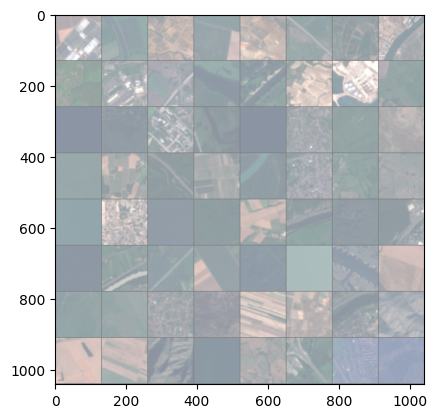

Predicted classes: ['Industrial', 'River', 'PermanentCrop', 'AnnualCrop', 'PermanentCrop', 'Highway', 'PermanentCrop', 'River', 'Pasture', 'Industrial', 'Highway', 'AnnualCrop', 'River', 'PermanentCrop', 'Industrial', 'Pasture', 'SeaLake', 'Forest', 'Industrial', 'River', 'SeaLake', 'Residential', 'Forest', 'HerbaceousVegetation', 'SeaLake', 'AnnualCrop', 'Highway', 'PermanentCrop', 'AnnualCrop', 'Residential', 'Pasture', 'PermanentCrop', 'SeaLake', 'Residential', 'SeaLake', 'Forest', 'AnnualCrop', 'River', 'Forest', 'Highway', 'SeaLake', 'Highway', 'Highway', 'AnnualCrop', 'Forest', 'SeaLake', 'River', 'AnnualCrop', 'Pasture', 'Pasture', 'Residential', 'HerbaceousVegetation', 'Highway', 'PermanentCrop', 'HerbaceousVegetation', 'HerbaceousVegetation', 'AnnualCrop', 'AnnualCrop', 'HerbaceousVegetation', 'SeaLake', 'PermanentCrop', 'Highway', 'Residential', 'HerbaceousVegetation']


In [131]:
# Get some test images
dataiter = iter(test_loader)
inputs, labels = next(dataiter)
inputs, labels = inputs.to(device), labels.to(device)

# Make predictions on the test images
model2.eval()
with torch.no_grad():
    outputs = model2(inputs)
    _, predicted = torch.max(outputs, 1)

# Display the images and predictions
imshow(torchvision.utils.make_grid(inputs.cpu()))
print("Predicted classes:", [class_labels[pred] for pred in predicted.cpu().numpy()])


We then construct the confusion matrix on the self-defined model. 

Prediction error occurs the most when the model predicts the image to be highway when the image actually is a river. 

Prediction error also occurs many times when the model predicts the image to be annualcrop when the image actually is a permanentcrop. (similar to pre-defined model)

The third most error occurs when the model predicts the image to be permanentcrop when the image actually is a HerbaceousVegetation.

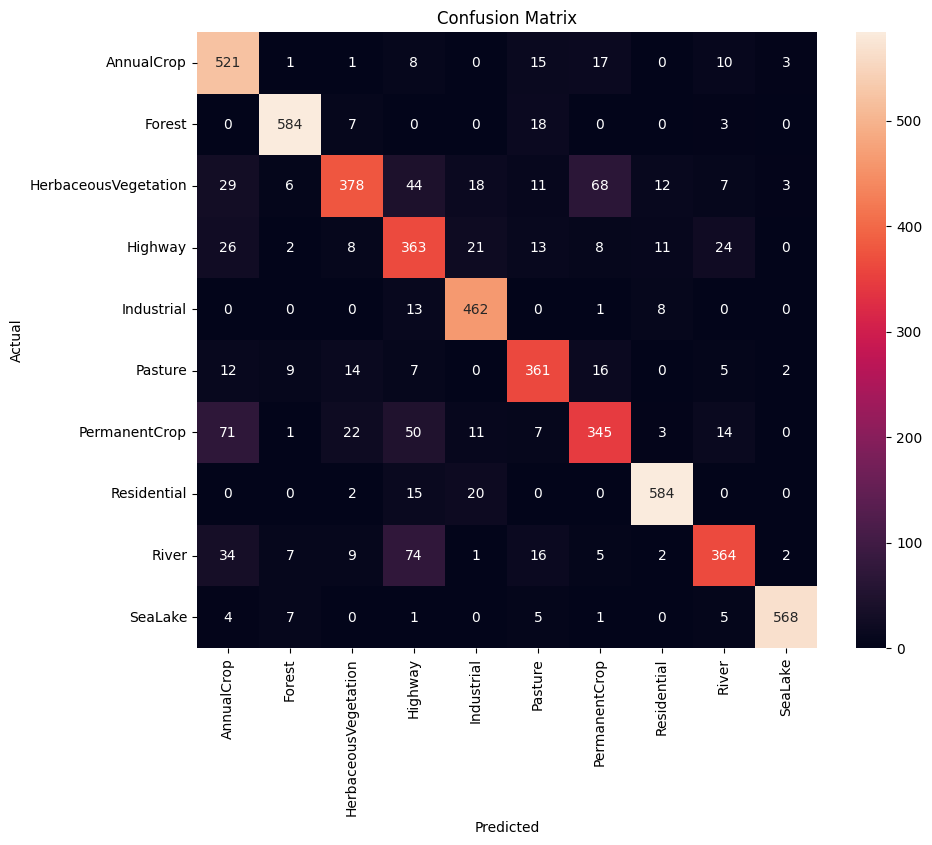

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(actual_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In conclusion, I have a test-set accuracy of 95.52% with pre-defined model and 83.89% with self-defined model, which I feel is good enough, for satellite image classification.